## Setup

In [1]:
## printing utils
#import yaml
#import inspect
#from IPython.display import Markdown, display
#from omegaconf import OmegaConf
import os
os.environ["HYDRA_FULL_ERROR"] = "1"

import hydra
with hydra.initialize('config', version_base='1.3'):
    cfg = hydra.compose("main", overrides=[
        'xp=unet_uv_drifters_aoml_15m_10y_11d_residu'
    ])


from pytorch_lightning import Trainer

trainer = Trainer(
  inference_mode=False,
  gradient_clip_val=0.5,
  accelerator='gpu',
  devices=1,
)

import torch 
lit_mod = hydra.utils.call(cfg.model)


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Odyssey/private/t22picar/miniforge3/envs/4dvarnet-d ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


n_channels
77
n_classes
22
ADD_INPUT


In [1]:
from src.models import Lit4dVarNet, GradSolverZero, BilinAEPriorCost, BaseObsCost, ConvLstmGradModel
from contrib.multivar.multivar_models import Multivar4dVarNet
from contrib.multivar.multivar_utils import MultivarBatchSelector
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

#import sys
#sys.path.append("/Odyssey/private/t22picar/4Dvarnet_uv/4dvarnet-starter/contrib/multivar/")
from contrib.multivar.parts import StandardBlock, ResBlock, Down, Up, OutConv

import kornia.filters as kfilts


class MultivarUNet(Multivar4dVarNet):
    def __init__(self,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.premiere_train = True  # Flag pour le premier step
        #print(self.logger)
        #print(self.solver)
        #print(self.trainer.log_dir)
        #self.save_norm_stat()

    def save_norm_stat(self):
        if self.logger:
            print(f"Saving norm at : {Path(self.logger.log_dir)}")
            print(self.norm_stats())
            with open(f"{Path(self.logger.log_dir)}"+'/norm_stats.pkl', 'wb') as f:
                pickle.dump(self._norm_stats, f)
        else:
            print("No self.logger")

    def multivar_step_mask(self, batch, phase=""):

        out = self(batch=batch)
        output_var_names = self.multivar_selector.multivar_output_var_names()
        size_t = out.size(1) // len(output_var_names)

        out = out.view(out.size(0), len(output_var_names), size_t, out.size(2), out.size(3))

        #print(out.shape)
        #print(self.multivar_selector.multivar_full_output(batch).shape)

        loss = None
        total_mse = None

        """
        if phase=="val":
            for i, var in enumerate(output_var_names):
                #TP : add mask nan
                #mask = ~torch.isnan(self.multivar_selector.multivar_obs_input(batch).view_as(out)[:,i])
                mask = (self.multivar_selector.multivar_obs_input(batch).view_as(out)[:,i] != 0).float() # 1 si != de 0 
                loss_i = self.weighted_mse((out[:,i] - self.multivar_selector.multivar_obs_input(batch).view_as(out)[:,i])*mask, self.rec_weight[:out.size(2)])
            #

        else:    
        """ 
        for i, var in enumerate(output_var_names):
            #TP : add mask nan
            #mask = ~torch.isnan(self.multivar_selector.multivar_full_output(batch).view_as(out)[:,i])
            # A changer
            mask = (self.multivar_selector.multivar_full_output(batch).view_as(out)[:,i] != self.multivar_selector.multivar_full_output(batch).view_as(out)[:,i][0][0][0]).float() # 1 si != de 0 
            #print(torch.sum(mask))

            loss_i = self.weighted_mse((out[:,i] - self.multivar_selector.multivar_full_output(batch).view_as(out)[:,i])*mask, self.rec_weight[:out.size(2)])
            with torch.no_grad():
                mse_i = 10000 * loss_i * self.output_norm_stats[1][i]**2
                self.log(f"{phase}_{var}_mse", mse_i, prog_bar=True, on_step=False, on_epoch=True)
                self.log(f"{phase}_{var}_loss", loss_i, prog_bar=True, on_step=False, on_epoch=True)
            loss = loss_i if loss is None else loss + loss_i
            total_mse = mse_i if total_mse is None else total_mse + mse_i

        with torch.no_grad():
            self.log(f"{phase}_total_mse", total_mse, prog_bar=True, on_step=False, on_epoch=True)
              
        return loss, out

    def step(self, batch, phase=""):

        #if self.premiere_train:
        #    print("C'est le premier validation step !")
        #    self.save_norm_stat()
        #    self.premiere_train=False

        
        # SKIP BATCH TO IMPLEMENT #
        if self.skip_batch(batch):
            return None, None

        #training_loss, out = self.multivar_step(batch, phase)
        training_loss, out = self.multivar_step_mask(batch, phase)

        return training_loss, out
    
    # Add dimensions 
    def forward(self, batch):
        batch_input = self.multivar_selector.multivar_prior_input(batch).nan_to_num()
        return self.solver(batch_input)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, block=ResBlock,
                 add_input=False):
        super(UNet, self).__init__()
        #self.block = ResBlock
        self.n_channels = n_channels
        print("n_channels")
        print(n_channels)
        self.n_classes = n_classes
        print("n_classes")
        print(n_classes)
        self.add_input = add_input
        self.bilinear = bilinear
        factor = 2 if bilinear else 1

        # block-wise weight scaling factors for stabilised gradients
        sfs = 1/torch.arange(1, 10).sqrt()
        
        # define modules
        self.inc = StandardBlock(n_channels, 64)
        self.down1 = Down(64, 128, block, sf=sfs[1])
        self.down2 = Down(128, 256, block, sf=sfs[2])
        self.down3 = Down(256, 512, block, sf=sfs[3])
        self.down4 = Down(512, 1024 // factor, block, sf=sfs[4])
        
        self.up1 = Up(1024, 512 // factor, block, bilinear, sf=sfs[5])
        self.up2 = Up(512, 256 // factor, block, bilinear, sf=sfs[6])
        self.up3 = Up(256, 128 // factor, block, bilinear, sf=sfs[7])
        self.up4 = Up(128, 64, block, bilinear, sf=sfs[8])
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        if self.add_input:
            inp = x[:,-1].unsqueeze(1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        out = self.outc(x)
        if self.add_input:
            out += inp

        return out

def cosanneal_lr_adam_unet(lit_mod, lr, T_max=100, weight_decay=0.):
    opt = torch.optim.Adam(
        [
            {"params": lit_mod.solver.parameters(), "lr": lr},
        ], weight_decay=weight_decay
    )
    return {
        "optimizer": opt,
        "lr_scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=T_max),
    }

def get_multivar_only_prior_dims_in(multivar_dict, channels_per_dim):

    dims_in = 0
    for var, var_info in multivar_dict.items():
        if var_info.input_arch == 'prior_input':
            dims_in+=1
    return dims_in * channels_per_dim


class MultivarUNet_weight(MultivarUNet):

    def __init__(self,*arg,weight,**kwargs):
        super(self).__init__(*arg,**kwargs)
        self.weight = weight

    def on_test_epoch_end(self):
        self.clear_gpu_mem()
        print('TEST DATA SIZE: {}'.format(torch.cat(self.test_data).size()))

        n_output_dims = self.test_data[0].shape[1]

        for output_dim in range(n_output_dims):
            rec_da = self.trainer.test_dataloaders.dataset.reconstruct_from_items(
                torch.cat(self.test_data).index_select(dim=1, index=torch.Tensor([output_dim]).type(torch.int64)).cuda(),
                self.weight.cpu().numpy()[:self.weight.cpu().numpy().shape[0]//n_output_dims]
            )

            if isinstance(rec_da, list):
                rec_da = rec_da[0]

            test_data = rec_da.assign_coords(
                dict(v0=self.test_quantities)
            ).to_dataset(dim='v0')

            metric_data = test_data.pipe(self.pre_metric_fn)
            metrics = pd.Series({
                metric_n: metric_fn(metric_data)
                for metric_n, metric_fn in self.metrics.items()
            })

            print(metrics.to_frame(name="Metrics").to_markdown())
            if self.logger:
                test_data.to_netcdf(Path(self.logger.log_dir) / f'test_data_dim{output_dim}.nc')
                print(Path(self.trainer.log_dir) / f'test_data_dim{output_dim}.nc')
                self.logger.log_metrics(metrics.to_dict())

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup() # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api*

{'lat': slice(-70, 70, None), 'lon': slice(-180, 180, None), 'time': slice('2011-01-01', '2011-03-01', None)}

handling [ugos] var
<xarray.DataArray 'ugos' (time: 60, lat: 560, lon: 1440)> Size: 194MB
[48384000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 480B 2011-01-01 2011-01-02 ... 2011-03-01
  * lat      (lat) float32 2kB -69.99 -69.73 -69.48 -69.23 ... 69.47 69.72 69.97
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
Attributes:
    units:          m/s
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity

handling [vgos] var
<xarray.DataArray 'vgos' (time: 60, lat: 560, lon: 1440)> Size: 194MB
[48384000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 480B 2011-01-01 2011-01-02 ... 2011-03-01
  * lat      (lat) float32 2kB -69.99 -69.73 -69.48 -69.23 ... 69.47 69.72 69.97
  * lon      (lon) float32 6kB -180.0 -1

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


full_input_idx: []
prior_input_idx: [tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(4, device='cuda:0'), tensor(7, device='cuda:0'), tensor(8, device='cuda:0')]
full_output_idx: [tensor(5, device='cuda:0'), tensor(6, device='cuda:0')]
state_obs_channels: []
state_obs_input_idx: []
Computing mean and std of training dataset ...
Remove fill nan during normalisation
Remove fill nan during normalisation
Norm stats computed (array([ 1.10033918e-02,  2.97982362e-04,  3.43510211e-01, -1.58408001e-01,
       -2.78661251e-01,  7.77480751e-02,  1.91124156e-02, -7.36365886e-03,
        3.97347900e+03]), array([1.64584070e-01, 1.32427633e-01, 7.01635063e-01, 5.22560120e+00,
       4.03000498e+00, 3.73890758e-01, 3.16484094e-01, 3.95086555e+01,
       1.54313806e+03]))


In [ ]:
import xarray as xr
sst_path= "/Odyssey/private/t22picar/data/sst_L4/SST_L4_OSTIA_2010-01-01-2019-01-01_4th.nc"
var_dataset = xr.Dataset({"sst":xr.open_dataset(sst_path)["thetao"]})


In [7]:
domain={'lat': slice(-70, 70, None), 'lon': slice(-180, 180, None), 'time': slice('2018-12-01', '2019-03-01', None)}
for domain_var_key in list(domain.keys()):
    if domain_var_key not in var_dataset.dims:
        del domain[domain_var_key]
print(domain)

{'lat': slice(-70, 70, None), 'lon': slice(-180, 180, None), 'time': slice('2018-12-01', '2019-03-01', None)}


In [8]:
var_dataset = var_dataset.sel(domain)

In [9]:
var_dataset

<xarray.Dataset> Size: 100MB
Dimensions:  (time: 31, lat: 560, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 248B 2018-12-01 2018-12-02 ... 2018-12-31
  * lat      (lat) float32 2kB -69.99 -69.73 -69.48 -69.23 ... 69.47 69.72 69.97
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
Data variables:
    sst      (time, lat, lon) float32 100MB ...

In [ ]:
trainer.fit(lit_mod, datamodule=dm, ckpt_path=None)

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Odyssey/private/t22picar/miniforge3/envs/4dvarnet-d ...
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Norm stats defined (array([-1.68143064e-01,  1.37182064e+01, -1.72705278e-01, -1.68878689e-01,
        5.00245733e-05,  4.78847733e-06]), array([6.95761800e-01, 1.14221401e+01, 5.05202723e+00, 4.03586960e+00,
       1.23083508e-02, 1.01268794e-02]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type | Params | Mode 
----------------------------------------
0 | solver | UNet | 17.8 M | train
----------------------------------------
17.8 M    Trainable params
0         Non-trainable params
17.8 M    Total params
71.260    Total estimated model params size (MB)


/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:  18%|█▊        | 4/22 [00:07<00:34,  0.51it/s, v_num=13755]

/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [6]:
train_dl = dm.test_dataloader() # # Split data into batch, selection of the etrainuation data + Computation of norm / Augmentation
train_ds = train_dl.dataset 
input_data = train_ds

In [7]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Récupérer des données du DataLoader
def get_data(dataloader, num_batches=1):
    data_list = []
    labels_list = []
    for i, (batch_data) in enumerate(dataloader):
        if i >= num_batches:
            break
        data_list.append(batch_data)
        print(f"Batch {i + 1}:")
        print("Data Shape:", batch_data.shape)
    return data_list[0].numpy()[-1] 

data  = get_data(train_dl)

Batch 1:
Data Shape: torch.Size([1, 4, 11, 680, 1440])


In [9]:
uo_gt = data[0,:,:,:]
vo_gt = data[1,:,:,:]
bathy = data[2,:,:,:]

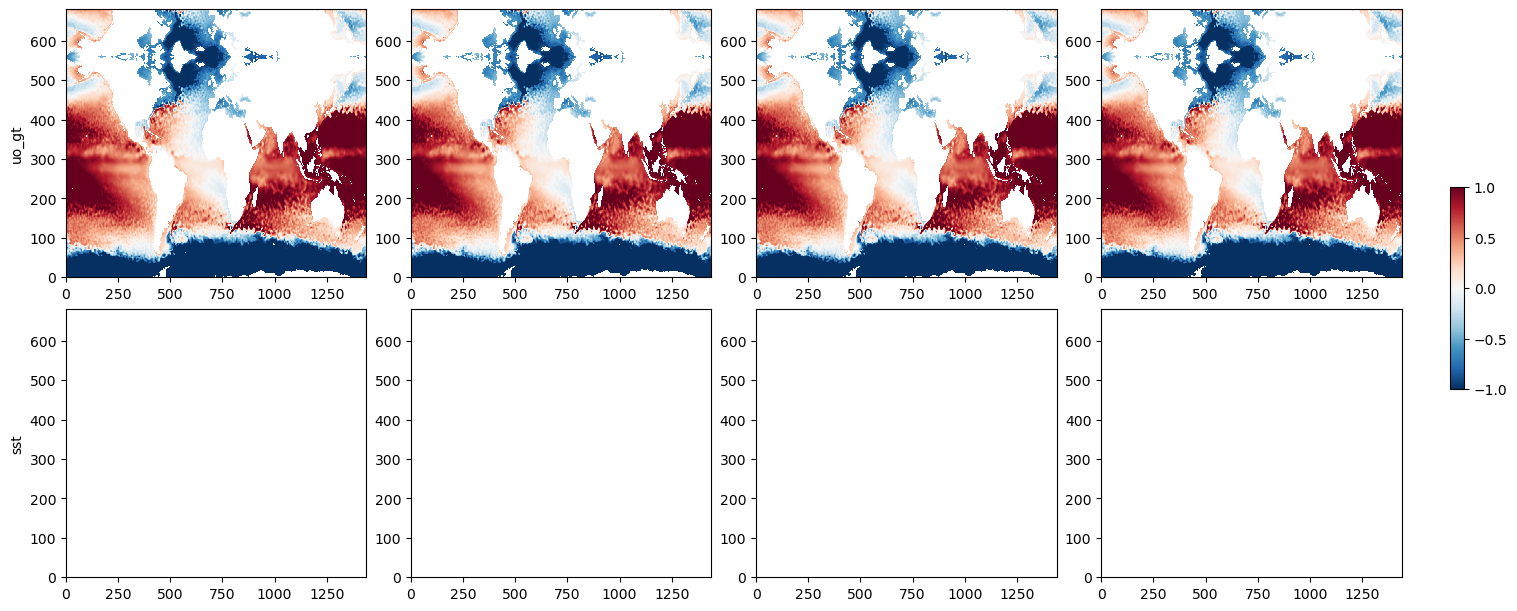

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         figsize=(14, 6), constrained_layout=True)
for i in [0,1]:
    for j in range(0,4):    
        ax = axes[i, j]
        if i==0:
            if j==0:
                ax.set_ylabel("uo_gt")
            c = ax.pcolormesh(uo_gt[j,:], cmap=plt.cm.RdBu_r,vmax=1,vmin=-1)
            plt.title("")
        else: 
            if j==0:
                ax.set_ylabel("sst")
            c = ax.pcolormesh(vo_gt[j,:], cmap=plt.cm.RdBu_r,vmax=1,vmin=-1)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")

In [25]:
vo_gt[0][0][0]

0.0036620640104544923

In [29]:
mask = (torch.tensor(vo_gt) != vo_gt[0][0][0]).float() # 1 si != de 0 

In [30]:
torch.sum(mask)

tensor(15626.)

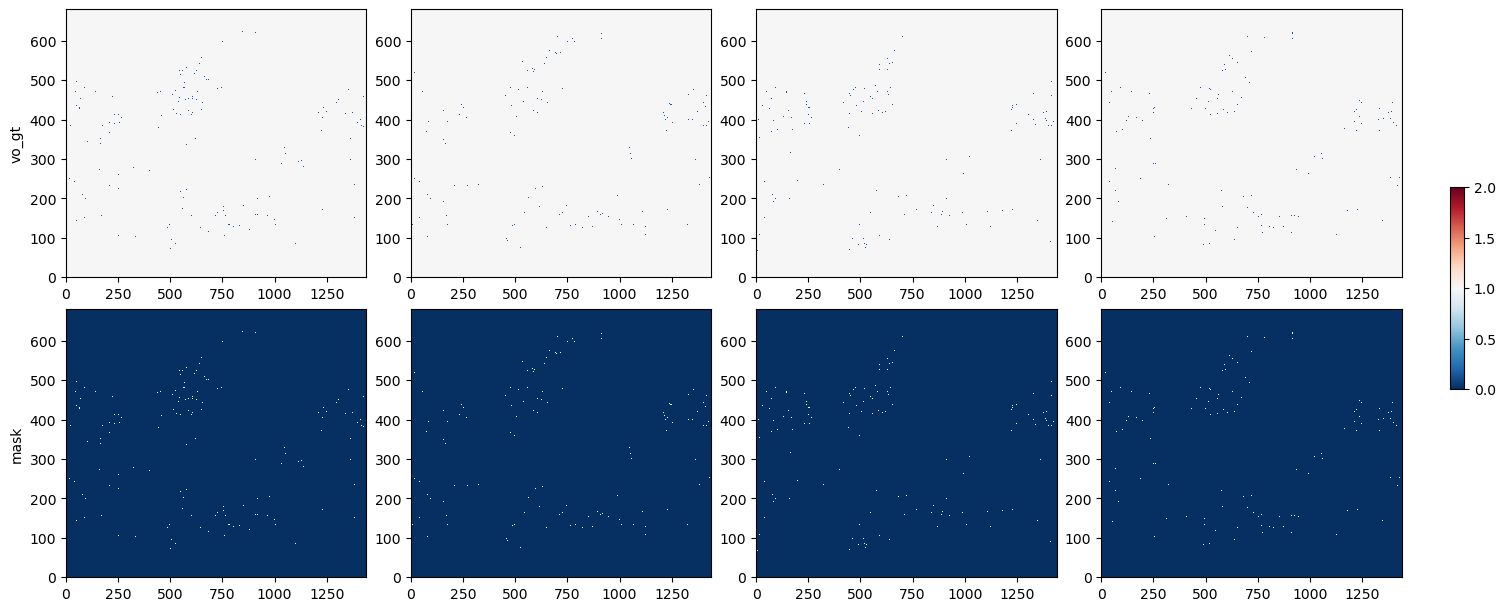

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         figsize=(14, 6), constrained_layout=True)
for i in [0,1]:
    for j in range(0,4):    
        ax = axes[i, j]
        if i==0:
            if j==0:
                ax.set_ylabel("vo_gt")
            c = ax.pcolormesh(vo_gt[j,:], cmap=plt.cm.RdBu_r,vmax=3,vmin=-3)
            plt.title("")
        else: 
            if j==0:
                ax.set_ylabel("mask")
            c = ax.pcolormesh(mask[j,:], cmap=plt.cm.RdBu_r,vmax=2,vmin=0)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")

In [23]:
plt.colorbar(mask[0,:,:])

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

<Figure size 640x480 with 0 Axes>

In [ ]:
enumerate(dataloader):
    if i >= num_batches:
        break
    print(f"Batch {i + 1}:")
    print("Labels:", batch_labels)

In [9]:
import matplotlib.pyplot as plt
import xarray as xr


# Sélection des données
selected_data = data.isel(time=slice(0, 20, 5))

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(nrows=selected_data.sizes['variable'], ncols=selected_data.sizes['time'],
                         figsize=(15, 8), constrained_layout=True)

# Parcourir chaque sous-graphique pour ajouter une colorbar
for i, variable in enumerate(selected_data['variable']):
    for j, time in enumerate(selected_data['time']):
        ax = axes[i, j]
        data_slice = selected_data.sel(variable=variable, time=time)
        c = ax.pcolormesh(data_slice, cmap=plt.cm.RdBu_r)
        if i<1:
            ax.set_title(f'Time: {time.values}')
        if j<1:
            ax.set_ylabel(f'Variable: {variable.values}')
    fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'isel'

In [14]:
import sys
sys.path.append("../tools")
from plot_tools import plot_uv_map,plot_map_zoom

In [29]:
data[0,15,:].shape

(680, 1440)

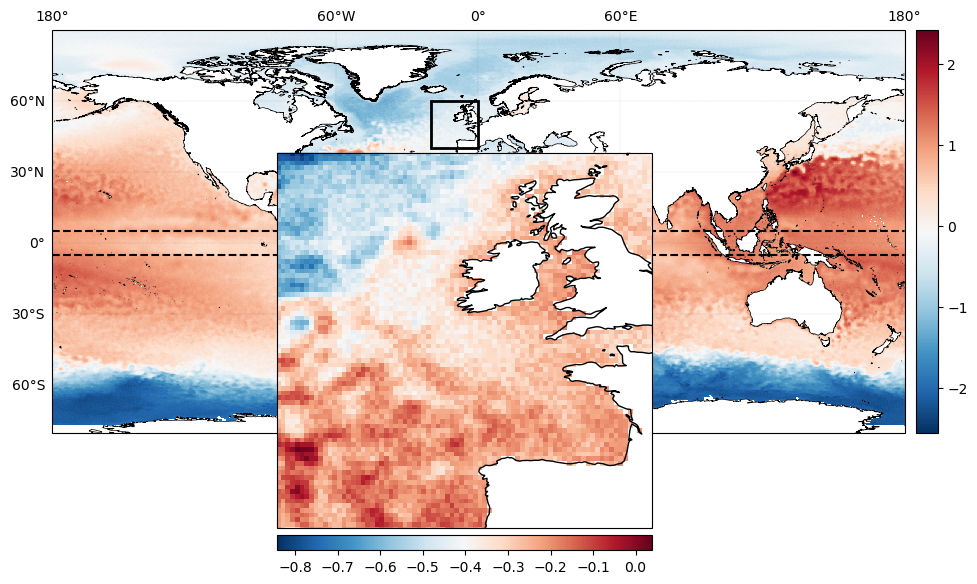

In [30]:
result_filepath = "/Odyssey/private/t22picar/data/glorys_2020_15m/glorys_15.81m_2020-01-20-2021-04-20_4th.nc"
res_data = xr.open_dataset(result_filepath)
plot_map_zoom(data[0,15,:],res_data.lon,res_data.lat)

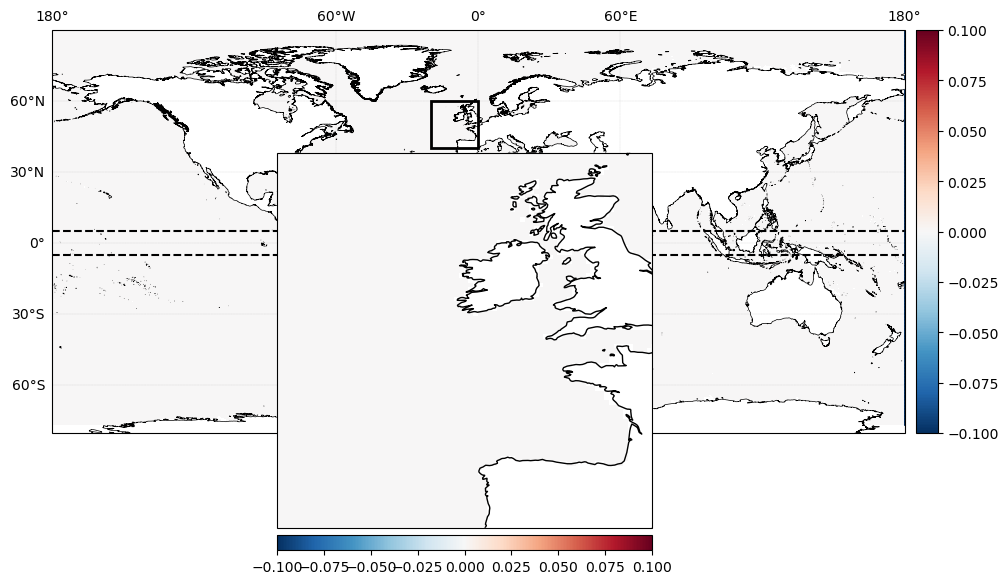

In [13]:
result_filepath = "/Odyssey/private/t22picar/data/glorys_2020_15m/glorys_15.81m_2020-01-20-2021-04-20_4th.nc"
res_data = xr.open_dataset(result_filepath)
plot_map_zoom(res_data.thetao[0]-input_data[1,0],res_data.lon,res_data.lat)

### Model


In [3]:
import torch 
lit_mod = hydra.utils.call(cfg.model)
#lit_mod.load_state_dict(torch.load('/Odyssey/private/t22picar/4Dvarnet_uv/4dvarnet-starter/outputs/2025-04-18/13-39-39/base_rec_global_multivar_theo_unet_1patch/val_mse=18.39735-epoch=006.ckpt')['state_dict'])

n_channels
77
n_classes
22
ADD_INPUT


In [4]:
val_dl = dm.val_dataloader() # # Split data into batch, selection of the evaluation data + Computation of norm / Augmentation
val_ds = val_dl.dataset 
input_data = val_ds.da 
print(f"\n{type(val_dl)=}\n\n{type(val_ds)=}\n\n{type(input_data)=}")


type(val_dl)=<class 'torch.utils.data.dataloader.DataLoader'>

type(val_ds)=<class 'contrib.multivar.multivar_data.MultivarXrDataset'>

type(input_data)=<class 'xarray.core.dataarray.DataArray'>


### Inference

In [5]:
batch = next(iter(val_dl))
ms = hydra.utils.call(cfg.multivar_selector)

In [6]:
lit_mod = lit_mod.to('cuda') # Move model to gpu for faster inference
batch = lit_mod.transfer_batch_to_device(batch, lit_mod.device, 0) # Move batch to same device
input_batch = ms.multivar_prior_input(batch.nan_to_num())
output_batch = ms.multivar_full_output(batch.nan_to_num())
lit_mod = lit_mod.eval() # Model in eval mode
solver = lit_mod.solver # we just need the solver for infering on one batch
c0 = val_ds.get_coords()[0]


with torch.no_grad():
    output = solver(input_batch)
print(f'{output.shape=}')

x
torch.Size([1, 77, 560, 1440])
inp
torch.Size([1, 22, 560, 1440])
Out + Add inp
torch.Size([1, 22, 560, 1440])
output.shape=torch.Size([1, 22, 560, 1440])


In [11]:
ssh_input =  input_batch[0,:].detach().cpu().numpy()
sst_input = input_batch[0,:].detach().cpu().numpy()
uo_predicted =  output[0,:].detach().cpu().numpy()
uo_gt = output_batch[0,:].detach().cpu().numpy()

uv_predicted = output_batch[0,:].detach().cpu().numpy()



In [12]:
import matplotlib.pyplot as plt

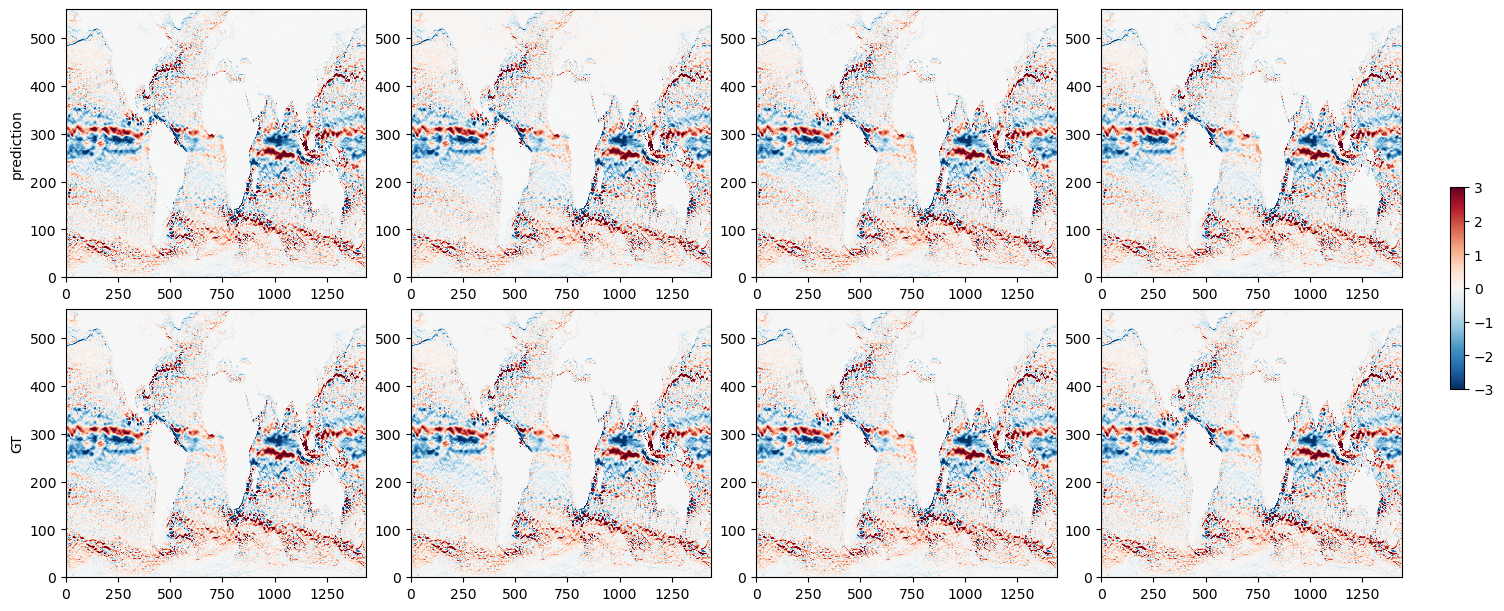

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         figsize=(14, 6), constrained_layout=True)
for i in [0,1]:
    for j in range(0,4):    
        ax = axes[i, j]
        if i==0:
            if j==0:
                ax.set_ylabel("prediction")
            c = ax.pcolormesh(uo_predicted[j,:], cmap=plt.cm.RdBu_r,vmax=3,vmin=-3)
            plt.title("")
        else: 
            if j==0:
                ax.set_ylabel("GT")
            c = ax.pcolormesh(ssh_input[j,:], cmap=plt.cm.RdBu_r,vmax=3,vmin=-3)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")

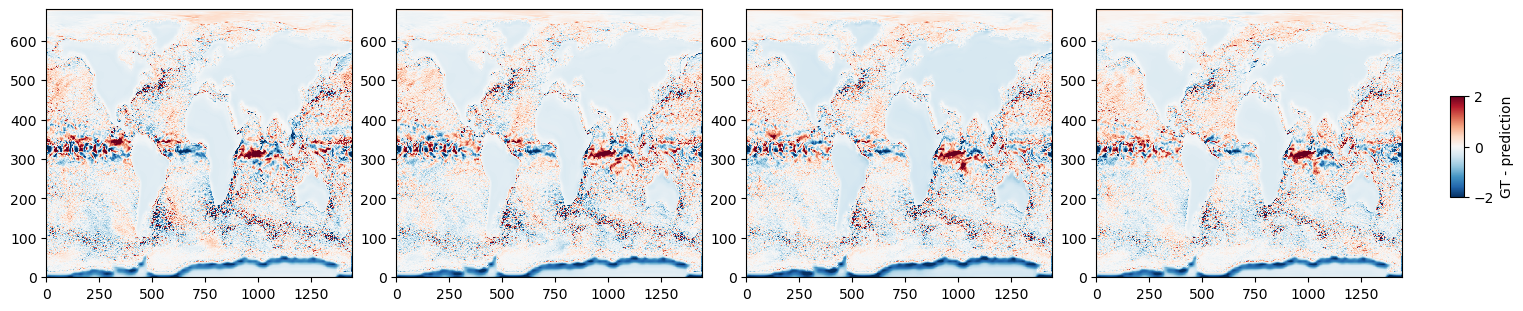

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4,
                         figsize=(14, 3), constrained_layout=True)
for j in range(0,4):    
        ax = axes[j]
        c = ax.pcolormesh(uo_gt[j,:]-uo_predicted[j,:], cmap=plt.cm.RdBu_r,vmax=2,vmin=-2)

cax = fig.add_axes([ax.get_position().x0+0.3,ax.get_position().y0+0.25,0.01,ax.get_position().width*2])
cbar = plt.colorbar(c,cax=cax,orientation="vertical")
cbar.set_label("GT - prediction")


In [ ]:
import pandas as pd 
file_metric = "/Odyssey/private/t22picar/4Dvarnet_uv/4dvarnet-starter/outputs/2025-04-04/16-16-18/base_forecast_global_multivar_theo/metrics.csv"
metrics = pd.read_csv(file_metric)

In [ ]:
metrics.val_loss.dropna().plot(label="val_loss")
metrics.train_loss.dropna().plot(label="train_loss")
plt.legend()

In [ ]:
metrics.val_mse.dropna().plot(label="val_mse")
metrics.train_mse.dropna().plot(label="train_mse")
plt.legend()